In [ ]:
import os
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Подготавливаем тренировочный набор данных

In [ ]:
filelist = os.listdir('/content/drive/MyDrive/VoiceRecognation/train_data')
train_df = pd.DataFrame(filelist)
train_df = train_df.rename(columns={0:'file'})

In [ ]:
ind = train_df[train_df['file']=='.DS_Store'].index[0]
train_df.drop(ind, inplace=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [ ]:
speaker = []
for i in range(0, len(train_df)):
    speaker.append(train_df['file'][i].split('-')[0])
train_df['speaker'] = speaker

In [ ]:
train_df

,file,speaker
0,2300-131720-0007.flac,2300
1,3570-5696-0000.flac,3570
2,1578-6379-0000.flac,1578
3,4640-19187-0025.flac,4640
4,6829-68771-0007.flac,6829
...,...,...
115,60-121082-0067.flac,60
116,8098-278252-0024.flac,8098
117,4970-29093-0003.flac,4970
118,441-128982-0032.flac,441


# Подготавливаем тестовый набор данных

In [ ]:
filelist = os.listdir('/content/drive/MyDrive/VoiceRecognation/test_data')
test_df = pd.DataFrame(filelist)
test_df = test_df.rename(columns={0:'file'})

In [ ]:
speaker = []
for i in range(0, len(test_df)):
    speaker.append(test_df['file'][i].split('-')[0])
test_df['speaker'] = speaker

In [ ]:
test_df

,file,speaker
0,60-121082-0011.flac,60
1,60-121082-0058.flac,60
2,60-121082-0039.flac,60
3,229-130880-0003.flac,229
4,229-130880-0065.flac,229
...,...,...
85,61-70970-0025.flac,61
86,61-70968-0035.flac,61
87,2300-131720-0027.flac,2300
88,2300-131720-0003.flac,2300


# Подготавливаем проверочный набор данных

In [ ]:
filelist = os.listdir('/content/drive/MyDrive/VoiceRecognation/valid_data')
valid_df = pd.DataFrame(filelist)
valid_df = valid_df.rename(columns={0:'file'})

In [ ]:
speaker = []
for i in range(0, len(valid_df)):
    speaker.append(valid_df['file'][i].split('-')[0])
valid_df['speaker'] = speaker

In [ ]:
valid_df

,file,speaker
0,60-121082-0048.flac,60
1,60-121082-0045.flac,60
2,60-121082-0000.flac,60
3,229-130880-0088.flac,229
4,229-130880-0032.flac,229
...,...,...
85,61-70970-0024.flac,61
86,4992-23283-0004.flac,4992
87,2300-131720-0011.flac,2300
88,2300-131720-0013.flac,2300


# Напишем функцию для извлечения звуковых свойств

In [ ]:
def extract_features(files):
    
# Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('/content/drive/MyDrive/VoiceRecognation/valid_data')+'/'+str(files.file))
# Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
# Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
# Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))
# Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
# Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
# Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
# Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)

    return mfccs, chroma, mel, contrast, tonnetz

# Подготавливаем тренировочный массив

In [ ]:
train_features = train_df.apply(extract_features, axis=1)

In [ ]:
train_features

0      ([-330.14413, 124.76181, -8.906253, 52.283108,...
1      ([-269.73224, 131.35336, -32.045166, 53.10115,...
2      ([-344.10193, 79.02399, -23.49361, 39.224873, ...
3      ([-345.053, 117.37512, -27.279285, 49.953636, ...
4      ([-316.1151, 100.63274, -40.081562, 49.680157,...
                             ...                        
115    ([-402.0331, 124.07726, -24.079449, 41.76991, ...
116    ([-405.74448, 126.56674, 2.3113189, 49.03396, ...
117    ([-364.4221, 71.019455, -38.20305, 41.17577, -...
118    ([-315.1131, 129.37952, -6.9333363, 59.152122,...
119    ([-364.32428, 84.79869, -59.779102, 69.66905, ...
Length: 120, dtype: object

In [ ]:
features_train = []
for i in range(0, len(train_features)):
    features_train.append(np.concatenate((
        train_features[i][0],
        train_features[i][1], 
        train_features[i][2], 
        train_features[i][3],
        train_features[i][4]), axis=0))

In [ ]:
X_train = np.array(features_train)

In [ ]:
X_train

array([[-3.30144135e+02,  1.24761810e+02, -8.90625286e+00, ...,
         1.45692074e-02, -4.84725256e-03,  1.26818161e-02],
       [-2.69732239e+02,  1.31353363e+02, -3.20451660e+01, ...,
         8.88461842e-02,  1.35060049e-02, -2.93650873e-02],
       [-3.44101929e+02,  7.90239868e+01, -2.34936104e+01, ...,
        -2.12299821e-02,  1.60057150e-02,  2.20019973e-03],
       ...,
       [-3.64422089e+02,  7.10194550e+01, -3.82030487e+01, ...,
        -2.16102384e-02, -3.94899270e-03,  1.13857243e-03],
       [-3.15113098e+02,  1.29379517e+02, -6.93333626e+00, ...,
         4.47693248e-02,  5.49279856e-02, -2.92803145e-02],
       [-3.64324280e+02,  8.47986908e+01, -5.97791023e+01, ...,
        -7.21271864e-03,  1.54164568e-02, -1.29754311e-03]])

# Подготавливаем тестовый массив

In [ ]:
test_features = test_df.apply(extract_features, axis=1)

In [ ]:
features_test = []
for i in range(0, len(test_features)):
    features_test.append(np.concatenate((
        test_features[i][0],
        test_features[i][1], 
        test_features[i][2], 
        test_features[i][3],
        test_features[i][4]), axis=0))

In [ ]:
X_test = np.array(features_test)

In [ ]:
X_test

array([[-3.58386536e+02,  1.40709290e+02, -3.34353867e+01, ...,
         3.81916541e-02,  4.94720146e-03, -6.12018329e-05],
       [-3.83483307e+02,  1.41357300e+02, -3.60273514e+01, ...,
        -7.08462541e-03,  1.66984347e-02,  2.95980356e-03],
       [-3.69524323e+02,  1.44874176e+02, -3.05833969e+01, ...,
        -2.80430771e-02,  5.49160025e-04,  3.35591228e-03],
       ...,
       [-3.43233246e+02,  1.30223358e+02, -1.73488846e+01, ...,
        -4.10676810e-03,  4.58444102e-03,  3.28371462e-03],
       [-3.31016724e+02,  1.30951950e+02, -1.51785650e+01, ...,
        -2.32867545e-03,  1.42770407e-03,  1.44815002e-03],
       [-3.24851379e+02,  1.31671402e+02, -2.15993938e+01, ...,
         2.25961897e-02,  6.09263284e-03, -6.69794072e-03]])

# Подготавливаем проверочный массив

In [ ]:
valid_features = valid_df.apply(extract_features, axis=1)

In [ ]:
features_valid = []
for i in range(0, len(valid_features)):
    features_valid.append(np.concatenate((
        valid_features[i][0],
        valid_features[i][1], 
        valid_features[i][2], 
        valid_features[i][3],
        valid_features[i][4]), axis=0))

In [ ]:
X_val = np.array(features_valid)

In [ ]:
X_val

array([[-3.87864716e+02,  1.28332352e+02, -2.76603222e+01, ...,
         9.12875849e-03,  1.42779027e-02, -1.82496879e-03],
       [-3.88258087e+02,  1.33968369e+02, -2.30281467e+01, ...,
         9.04491773e-03,  7.67332526e-03,  3.48687574e-03],
       [-3.64714478e+02,  1.45245056e+02, -4.19271088e+01, ...,
        -3.85586769e-02,  3.16894874e-03, -2.92656827e-03],
       ...,
       [-2.78502960e+02,  1.35235077e+02, -2.13599396e+01, ...,
         3.10760156e-02,  1.57266134e-03,  4.05455407e-04],
       [-3.10141174e+02,  1.42646866e+02, -2.21377411e+01, ...,
        -2.32570757e-02, -2.00056433e-03,  3.96258578e-04],
       [-3.02977448e+02,  1.35470734e+02, -1.08759336e+01, ...,
         8.34106507e-04, -1.96564580e-03,  6.26333572e-03]])

# Получаем идентификаторы спикеров

In [ ]:
y_train = np.array(train_df['speaker'])
y_val = np.array(valid_df['speaker'])
y_test = np.array(test_df['speaker'])

## Применим LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

In [ ]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_val = to_categorical(lb.fit_transform(y_val))

# Масштабируем X-наборы

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

# Построение нейронной сети

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()

model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    

model.add(Dense(30, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

## Подбираем модель с данными обучения и проверки

In [ ]:
history = model.fit(X_train, y_train, batch_size=256, epochs=100, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

Epoch 1/100
1/1 [==============================] - 1s 619ms/step - loss: 3.8515 - accuracy: 0.0333 - val_loss: 3.3965 - val_accuracy: 0.0333
Epoch 2/100
1/1 [==============================] - 0s 30ms/step - loss: 3.5695 - accuracy: 0.0417 - val_loss: 3.2873 - val_accuracy: 0.0667
Epoch 3/100
1/1 [==============================] - 0s 26ms/step - loss: 3.3519 - accuracy: 0.0417 - val_loss: 3.1986 - val_accuracy: 0.1556
Epoch 4/100
1/1 [==============================] - 0s 25ms/step - loss: 3.2480 - accuracy: 0.0833 - val_loss: 3.1214 - val_accuracy: 0.2333
Epoch 5/100
1/1 [==============================] - 0s 25ms/step - loss: 3.2312 - accuracy: 0.0583 - val_loss: 3.0514 - val_accuracy: 0.3000
Epoch 6/100
1/1 [==============================] - 0s 28ms/step - loss: 3.0543 - accuracy: 0.1333 - val_loss: 2.9848 - val_accuracy: 0.3667
Epoch 7/100
1/1 [==============================] - 0s 26ms/step - loss: 3.0206 - accuracy: 0.1583 - val_loss: 2.9194 - val_accuracy: 0.3889
Epoch 8/100
1/1 [==

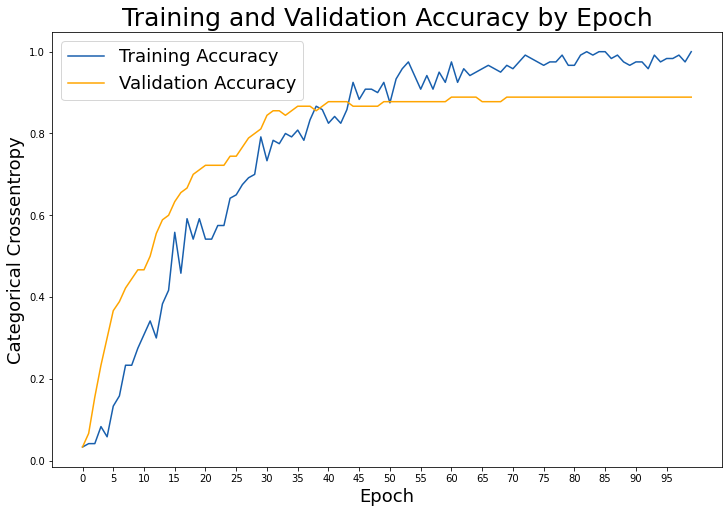

In [ ]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);

In [ ]:
# We get our predictions from the test data
predictions=model.predict(X_test) 
predictions_classes=np.argmax(predictions,axis=1)
# We transform back our predictions to the speakers ids
predictions_classes = lb.inverse_transform(predictions_classes)
# Finally, we can add those predictions to our original dataframe
test_df['predictions'] = predictions_classes

In [ ]:
# Code to see which values we got wrong
test_df[test_df['speaker'] != test_df['predictions']]

,file,speaker,predictions
57,121-127105-0024.flac,121,1898
64,237-126133-0000.flac,237,1580
75,121-127105-0023.flac,121,1898
81,8555-292519-0005.flac,8555,3570


In [ ]:
# Code to see the numerical accuracy
(1-round(len(test_df[test_df['speaker'] != test_df['predictions']])/len(test_df),3))*100

95.6